In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testimages/test_02.png
/kaggle/input/testimages/example_test.png
/kaggle/input/testimages/test_04.png
/kaggle/input/testimages/test_03.png
/kaggle/input/testimages/test_05.png
/kaggle/input/testimages/test_01.png


In [34]:
cd /kaggle/input/testimages

/kaggle/input/testimages


In [35]:
ls

example_test.png  test_02.png  test_04.png
test_01.png       test_03.png  test_05.png


In [36]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [37]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt

In [38]:
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

In [39]:
image = cv2.imread('example_test.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

In [40]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

In [41]:
if len(cnts) > 0:
	# sort the contours according to their size in
	# descending order
	cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

	# loop over the sorted contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)

		# if our approximated contour has four points,
		# then we can assume we have found the paper
		if len(approx) == 4:
			docCnt = approx
			break

In [42]:
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

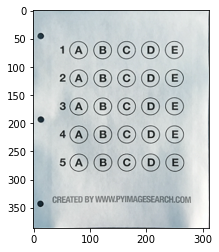

In [43]:
plt.imshow(paper)

In [44]:
thresh = cv2.threshold(warped, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

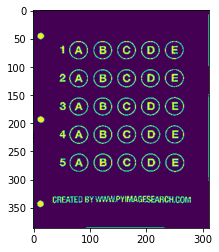

In [45]:
plt.imshow(thresh)

In [46]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []

In [47]:
for c in cnts:
	# compute the bounding box of the contour, then use the
	# bounding box to derive the aspect ratio
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)

	# in order to label the contour as a question, region
	# should be sufficiently wide, sufficiently tall, and
	# have an aspect ratio approximately equal to 1
	if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
		questionCnts.append(c)

In [48]:
questionCnts = contours.sort_contours(questionCnts,method="top-to-bottom")[0]
correct = 0

In [49]:
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
	# sort the contours for the current question from
	# left to right, then initialize the index of the
	# bubbled answer
	cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
	bubbled = None

	# loop over the sorted contours
	for (j, c) in enumerate(cnts):
		# construct a mask that reveals only the current
		# "bubble" for the question
		mask = np.zeros(thresh.shape, dtype="uint8")
		cv2.drawContours(mask, [c], -1, 255, -1)

		# apply the mask to the thresholded image, then
		# count the number of non-zero pixels in the
		# bubble area
		mask = cv2.bitwise_and(thresh, thresh, mask=mask)
		total = cv2.countNonZero(mask)

		# if the current total has a larger number of total
		# non-zero pixels, then we are examining the currently
		# bubbled-in answer
		if bubbled is None or total > bubbled[0]:
			bubbled = (total, j)

	# initialize the contour color and the index of the
	# *correct* answer
	color = (255, 0, 0)
	k = ANSWER_KEY[q]

	# check to see if the bubbled answer is correct
	if k == bubbled[1]:
		color = (0, 255, 0)
		correct += 1

	# draw the outline of the correct answer on the test
	cv2.drawContours(paper, [cnts[k]], -1, color, 3)


[INFO] score: 40.00%


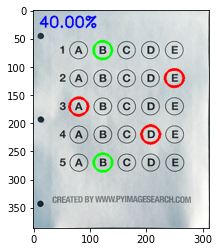

In [50]:
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
plt.imshow(image)
plt.imshow(paper)
